# Problem set #3: Regression diagnostics, interaction terms, and missing data

In [1]:
import numpy as np
import pandas
import statsmodels
import statsmodels.formula.api
import statsmodels.stats.api
import statsmodels.stats
import statsmodels.stats.outliers_influence
import statsmodels.graphics.regressionplots
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

In [2]:
np.random.seed(seed=1234)
bidenFname = 'data/biden.csv'
df = pandas.read_csv(bidenFname).dropna()

## Regression diagnostics

In [3]:
model1 = statsmodels.formula.api.ols('biden ~ female + age + educ', data=df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     16.82
Date:                Mon, 15 May 2017   Prob (F-statistic):           8.88e-11
Time:                        01:21:16   Log-Likelihood:                -8240.4
No. Observations:                1807   AIC:                         1.649e+04
Df Residuals:                    1803   BIC:                         1.651e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     68.6210      3.596     19.083      0.0

### Part 1

In [4]:
outliersDf = statsmodels.stats.outliers_influence.OLSInfluence(model1).summary_frame()

In [5]:
outliersDf.max()

dfb_Intercept      0.146815
dfb_female         0.073718
dfb_age            0.103533
dfb_educ           0.209949
cooks_d            0.012624
dffits             0.151820
dffits_internal    0.151788
hat_diag           0.018368
standard_resid     1.950243
student_resid      1.951762
dtype: float64

In [6]:
outliersDf.min()

dfb_Intercept     -1.707944e-01
dfb_female        -6.420817e-02
dfb_age           -1.750465e-01
dfb_educ          -1.257567e-01
cooks_d            4.782469e-11
dffits            -2.249932e-01
dffits_internal   -2.247168e-01
hat_diag           1.015680e-03
standard_resid    -2.899547e+00
student_resid     -2.905524e+00
dtype: float64

We can see fomt the tables above that $DFBETA$ values for some of the data points are quite signifcant and at least one has a cook's D much greater than $4/n$.

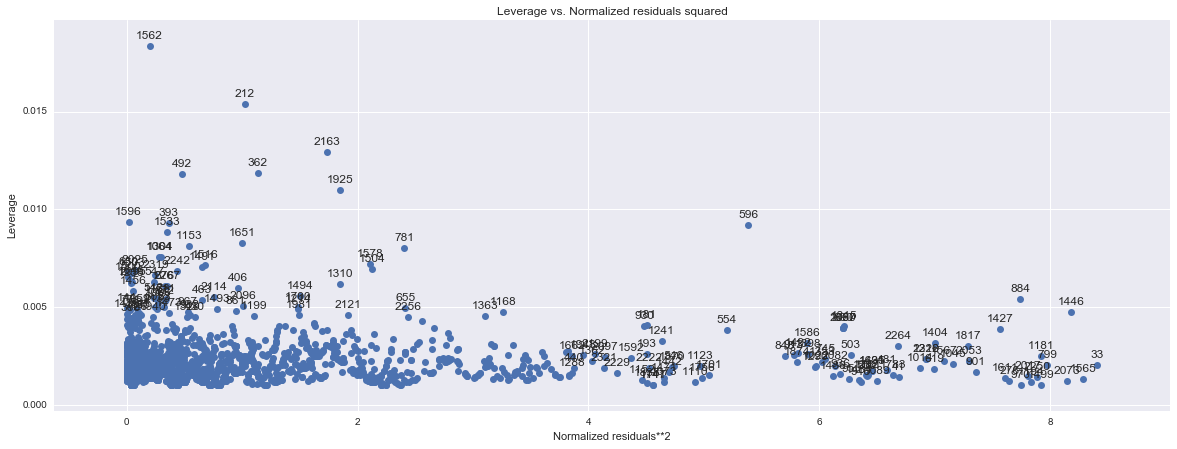

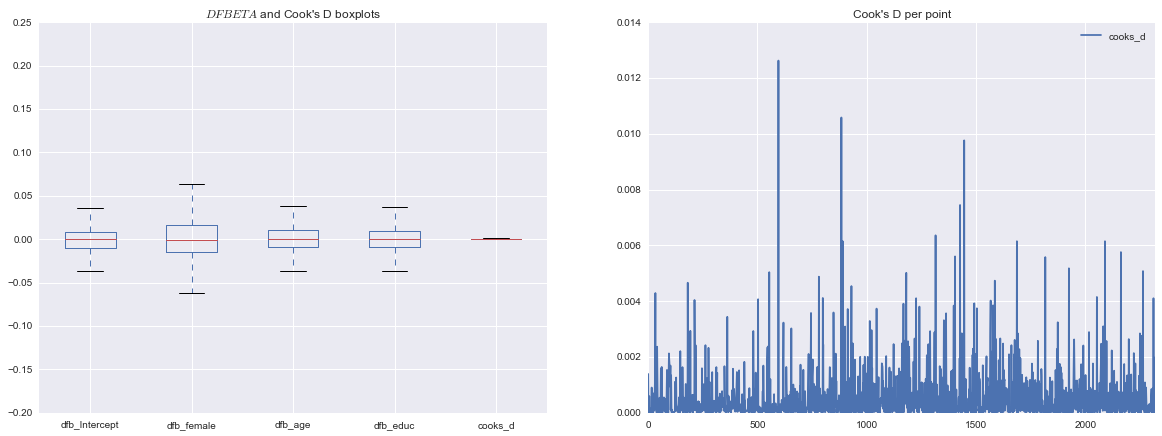

In [7]:
fig, ax = plt.subplots(figsize = (20, 7))
fig = statsmodels.graphics.regressionplots.plot_leverage_resid2(model1, ax = ax)
plt.show()
fig, axes = plt.subplots(ncols=2, figsize = (20, 7))
outliersDf[['dfb_Intercept', 'dfb_female', 'dfb_age', 'dfb_educ', 'cooks_d']].boxplot(ax = axes[0])
axes[0].set_title('$DFBETA$ and Cook\'s D boxplots')
outliersDf[['cooks_d']].plot(ax = axes[1])
axes[1].set_title('Cook\'s D per point')
plt.show()

Plotting them shows that there are a fair number of influential points (the point labels are original indices of the points). We would first need to determine the criteria for classifying them as outliers. Cook's D above a certain value would be a good starting point. Once we identify them we could drop them. We could also check if they are only influential in one dimension and normalize that dimension to the mean or some other less significant values, while keeping the other values.

### Part 2

In [8]:
names = ['$\chi^2_2$', 'p-value', 'Skew', 'Kurtosis']
test = statsmodels.stats.api.jarque_bera(model1.resid)
nonNormDF = pandas.DataFrame({n : [test[i]] for i, n in enumerate(names)})
nonNormDF

,$\chi^2_2$,Kurtosis,Skew,p-value
0,67.836979,3.055718,-0.473784,1.859461e-15


As shown by the large $\chi^2_2$ value of the Jarque Bera test the p-value is much to low for the errors to be normally distributed. The fix for this depends on the distribution of the errors, there may be a simple transform that makes them normal, if so we can apply it. If not we may need to rethink our regression 

### Part 3

In [9]:
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = statsmodels.stats.api.het_breushpagan(model1.resid, model1.model.exog)
heteroTestDF = pandas.DataFrame({n : [test[i]] for i, n in enumerate(names)})
heteroTestDF

,Lagrange multiplier statistic,f p-value,f-value,p-value
0,22.559407,0.000048,7.598013,0.00005


As shown in the table the Breusch–Pagan test indicates (p-value $< .05$) there is some heteroskedasticity in the data. This could greatly affect our inference since some regions have lower error than others and as such our accuracy is dependant on the input.

### Part 4

In [63]:
names = ['Intercept','female','age','educ']
multicollinearityDF = pandas.DataFrame({n : [model1.eigenvals[i]] for i, n in enumerate(names)})
multicollinearityDF

,Intercept,age,educ,female
0,4.885636e+06,454.800615,41.275382,48096.266665


By looking at the eigenvalues of the correlation matrix we can see that there is likely no multicollinearity since they are all quite large and thus independent.

## Interaction terms

In [11]:
model2 = statsmodels.formula.api.ols('biden ~ age + educ + age * educ', data=df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     10.74
Date:                Mon, 15 May 2017   Prob (F-statistic):           5.37e-07
Time:                        01:21:19   Log-Likelihood:                -8249.3
No. Observations:                1807   AIC:                         1.651e+04
Df Residuals:                    1803   BIC:                         1.653e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     38.3735      9.564      4.012      0.0

### Part 1

From this table we can see that the the marginal effect of $age$ on $biden$ is $0.6719 - 0.0480educ$, thus it is postive for $educ < \frac{0.6719}{0.0480} \sim 14$ and negative for other values of $educ$.

In [12]:
print(model2.wald_test('age + age:educ').summary())

<F test: F=array([[ 15.61971126]]), p=8.043107684540588e-05, df_denom=1803, df_num=1>


We can see from the Wald test of for this marginal effect that the null hypothesis of no effect is soundly defeated with $p < .05$

### Part 2

From the summary table we can see that the the marginal effect of $educ$ (education) on $biden$ is $1.6574 - 0.0480age$, thus it is postive for $age < \frac{1.6574}{0.0480} \sim 35$ and negative for other values $age$.

In [13]:
print(model2.wald_test('educ + age:educ').summary())

<F test: F=array([[ 5.25945763]]), p=0.021942412688529922, df_denom=1803, df_num=1>


We can see from the Wald test of for this marginal effect that the null hypothesis of no effect is barely defeated for $p < .05$

## Missing data

In [14]:
fullDF = pandas.read_csv(bidenFname)

In [50]:
imputer = sklearn.preprocessing.Imputer(strategy='mean')
imputedMeanDF = pandas.DataFrame(imputer.fit_transform(fullDF), columns = ['biden','female','age','educ','dem','rep'])
modelMean = statsmodels.formula.api.ols('biden ~ female + age + educ', data=imputedMeanDF).fit()
print(modelMean.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     14.16
Date:                Mon, 15 May 2017   Prob (F-statistic):           3.81e-09
Time:                        01:35:47   Log-Likelihood:                -10350.
No. Observations:                2323   AIC:                         2.071e+04
Df Residuals:                    2319   BIC:                         2.073e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     64.7003      2.718     23.802      0.0

Above is the summary table for the model trained with imputed data, where missing values are replaced with their mean.

In [17]:
imputer = sklearn.preprocessing.Imputer(strategy='median')
imputedMedianDF = pandas.DataFrame(imputer.fit_transform(fullDF), columns = ['biden','female','age','educ','dem','rep'])
modelMedian = statsmodels.formula.api.ols('biden ~ female + age + educ', data=imputedMedianDF).fit()
print(modelMedian.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     13.07
Date:                Mon, 15 May 2017   Prob (F-statistic):           1.84e-08
Time:                        01:22:05   Log-Likelihood:                -10353.
No. Observations:                2323   AIC:                         2.071e+04
Df Residuals:                    2319   BIC:                         2.074e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     63.3485      2.722     23.271      0.0

Above is the summary table for the model trained with imputed data, where missing values are replaced with their median.

In [32]:
betasDF = pandas.DataFrame([model1.params, modelMean.params,modelMedian.params], index =['Base', 'Mean', 'Median'])
betasDF

,Intercept,female,age,educ
Base,68.621014,6.196069,0.041879,-0.888713
Mean,64.700344,4.679256,0.034906,-0.537671
Median,63.348473,4.589444,0.037860,-0.471205


Table of parameters for the base (row wise dropping) and imputed models

In [53]:
errsDF = pandas.DataFrame([model1.bse, modelMean.bse,modelMedian.bse], index =['Base', 'Mean', 'Median'])
errsDF

,Intercept,female,age,educ
Base,3.596005,1.096697,0.032486,0.224692
Mean,2.718289,0.874118,0.025371,0.168672
Median,2.722178,0.875347,0.025407,0.168913


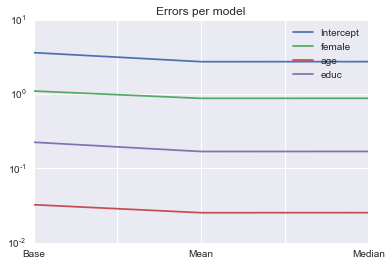

In [56]:
errsDF.plot(logy=1)
plt.title('Errors per model')
plt.show()

We can see from the table and plot that imputation has some effect on the model parameters. The main difference is in the standard errors which the summary table and plot (note it is log-lin) shows that imputation lowers them by a significant amount. This is not surprising since we are considering the data to be multivariate normal in the mean case and our imputed points are decreasing the variance. If the data are multivariate normal the median imputation will have the same effect, but since it leads to slightly different parameters we can deuce that there is some non-normality in the data. A next step would be to check this formally, maybe with Henze-Zirkler's multivariate normality test and find a transform to increase normality before imputing.